In [356]:
import math
import random
from datetime import date
import warnings
from typing import List, Optional

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences, LocalStandardScaler, GlobalSklearnTransformer
from mlforecast.feature_engineering import transform_exog
from utilsforecast.feature_engineering import fourier, trend, pipeline

from numba import njit
from scipy import stats
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import MinMaxScaler, RobustScaler, FunctionTransformer, OneHotEncoder, TargetEncoder

from sklearn.linear_model import LinearRegression
from window_ops.rolling import rolling_mean
from xgboost import XGBRegressor


# Suppress warnings
warnings.filterwarnings('ignore')

# MLforecast evaluation class

In [357]:
class MLForecast_Evaluator:
    def __init__(self, fcst, valid, future_df, h=1):
        self.fcst = fcst
        self.valid = valid
        self.future_df = future_df
        self.h = h
        self.mean_rmse_valid = None # To use for filename (mean rmse of all models)
        
        # Generate predictions
        self.predictions = fcst.predict(h=self.h, X_df=future_df)
        # Replace negative predictions with 0
        numeric_cols = self.predictions.select_dtypes(include=[np.number])
        numeric_cols[numeric_cols < 0] = 0
        self.predictions[numeric_cols.columns] = numeric_cols

        # Merge predictions with valid set
        self.results = valid.merge(self.predictions, on=['unique_id', 'ds'])
        
        # Get fitted values (train predictions)
        self.train_preds = fcst.forecast_fitted_values()
        
        # Identify model columns
        self.model_columns = list(fcst.models.keys())
        
    def plot_time_series(self, n_samples: int = 4, figsize: tuple = None, random_state: Optional[int] = None):
        """
        Plots the time series for a random sample of unique_ids.
        
        Parameters
        ----------
        """
        
        # Sample random unique_ids
        unique_ids = self.train_preds['unique_id'].unique()
        sampled_ids = np.random.choice(unique_ids, size=min(n_samples, len(unique_ids)), replace=False)
        
        # Calculate grid dimensions
        n_cols = math.ceil(math.sqrt(n_samples))
        n_rows = math.ceil(n_samples / n_cols)
        
        # Calculate adaptive figsize if not provided
        if figsize is None:
            figsize = (7 * n_cols, 4 * n_rows)
        
        # Create subplots
        fig, axs = plt.subplots(n_rows, n_cols, figsize=figsize)
        fig.suptitle('Time Series Visualization', fontsize=16)

        axs = axs.flatten() if n_samples > 1 else [axs]

        # List to store handles and labels for the legend
        handles, labels = [], []

        for i, unique_id in enumerate(sampled_ids):
            train_data = self.train_preds[self.train_preds['unique_id'] == unique_id]
            valid_data = self.results[self.results['unique_id'] == unique_id]

            # Plot train data
            h_train, = axs[i].plot(train_data['ds'], train_data['y'], label='Actual (Train)', color='black')
            if 'Actual (Train)' not in labels:
                handles.append(h_train)
                labels.append('Actual (Train)')

            for model in self.model_columns:
                h_model_train, = axs[i].plot(train_data['ds'], train_data[model], label=f'{model} (Train)')
                if f'{model} (Train)' not in labels:
                    handles.append(h_model_train)
                    labels.append(f'{model} (Train)')
            
            # Plot valid data
            h_valid, = axs[i].plot(valid_data['ds'], valid_data['y'], label='Actual (Valid)', color='red', linestyle='--')
            if 'Actual (Valid)' not in labels:
                handles.append(h_valid)
                labels.append('Actual (Valid)')

            for model in self.model_columns:
                h_model_valid = axs[i].scatter(valid_data['ds'], valid_data[model], label=f'{model} (Valid)')
                if f'{model} (Valid)' not in labels:
                    handles.append(h_model_valid)
                    labels.append(f'{model} (Valid)')

            axs[i].set_title(f'Time Series - ID: {unique_id}')
            axs[i].set_xlabel('Date')
            axs[i].set_ylabel('Value')
        
        # Remove any unused subplots
        for j in range(i + 1, len(axs)):
            fig.delaxes(axs[j])
        
        # Add a single legend for all subplots
        fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5, 1.05), ncol=len(self.model_columns) + 2, fontsize='small')
        plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust layout to make room for the legend
        plt.show()

    def calculate_metrics(self) -> pd.DataFrame:
        metrics = {}

        for model in self.model_columns:
            model_metrics = {}
            for result_df, name in zip([self.train_preds, self.results], ['train', 'valid']):
                y_true = result_df['y']
                y_pred = result_df[model]

                model_metrics[f'RMSE_{name}'] = np.sqrt(mean_squared_error(y_true, y_pred))
                model_metrics[f'R2_{name}'] = r2_score(y_true, y_pred)

            metrics[model] = model_metrics

        metrics_df = pd.DataFrame(metrics).T

        # Find the model with the lowest validation RMSE
        lowest_rmse_model = metrics_df['RMSE_valid'].idxmin()
        lowest_rmse_value = metrics_df.loc[lowest_rmse_model, 'RMSE_valid']
        
        self.mean_rmse_valid = metrics_df['RMSE_valid'].mean()  # Calculate and store mean RMSE for submission

        print(f"MEAN RMSE_VALID = {self.mean_rmse_valid}\n")
        print(f"Model with lowest RMSE validation is {lowest_rmse_model} with RMSE = {lowest_rmse_value}\n")
        print(metrics_df.sort_values(by='RMSE_valid'))

        return metrics_df.sort_values(by='RMSE_valid')
    
    def plot_feature_importances(self):
        # Initialize an empty DataFrame to store the feature importances
        df = pd.DataFrame()

        # Loop through each model to get its feature importances
        for model in self.model_columns:
            feature_importances = self.fcst.models_[model].feature_importances_
            feature_names = self.fcst.ts.features_order_

            # Create a temporary DataFrame for the current model
            temp_df = pd.DataFrame(feature_importances, columns=[model], index=feature_names)

            # Merge the temporary DataFrame with the main DataFrame
            if df.empty:
                df = temp_df
            else:
                df = df.join(temp_df, how='outer')

        # Fill NaNs with 0 (if any feature is missing in some models)
        df = df.fillna(0)
        # Scale the feature importances between 0 and 1 for each model
        scaler = MinMaxScaler()
        df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)

        # Sort features by their average importance
        average_importance = df_scaled.mean(axis=1)
        sorted_features = average_importance.sort_values(ascending=True).index[-50:]

        # Reorder DataFrame according to the sorted feature list
        df_scaled = df_scaled.loc[sorted_features]

        # Plotting the horizontal multi-bar plot
        fig, ax = plt.subplots(figsize=(10, 15))

        # Define the height of the bars and the positions for each group
        bar_height = 0.15
        index = np.arange(len(sorted_features))

        # Loop through each model and plot its feature importances
        for i, model in enumerate(self.model_columns):
            ax.barh(index + i * bar_height, df_scaled[model], bar_height, label=model)

        # Add labels, title, and legend
        ax.set_ylabel('Feature')
        ax.set_xlabel('Scaled Importance')
        ax.set_title('Scaled Feature Importances by Model')
        ax.set_yticks(index + bar_height * (len(self.model_columns) - 1) / 2)
        ax.set_yticklabels(sorted_features)
        ax.legend()

        plt.tight_layout()
        plt.show()


    def plot_metrics(self):
        
        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

        # Plot 1: Scatter plot of predicted vs actual values
        for model in self.model_columns:
            # Scatter plot
            sns.scatterplot(x=self.results[model], y=self.results['y'], label=model, ax=ax1, alpha=0.7)
            
            # Fit line
            X = self.results[model].values.reshape(-1, 1)
            y = self.results['y'].values
            reg = LinearRegression().fit(X, y)
            ax1.plot(X, reg.predict(X))

        # Plot the perfect prediction line
        min_val = min(self.results['y'].min(), self.results[self.model_columns].min().min())
        max_val = max(self.results['y'].max(), self.results[self.model_columns].max().max())
        ax1.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect prediction')

        ax1.set_xlabel('Predicted Value')
        ax1.set_ylabel('Actual Value')
        ax1.set_title('Validation Set: Predicted vs Actual')
        ax1.legend(title='Model')

        # Plot 2: Distribution of Residuals
        scaler = RobustScaler()  # RobustScaler is less sensitive to outliers
        palette = sns.color_palette(n_colors=len(self.model_columns))
        
        for i, model in enumerate(self.model_columns):
            # Calculate residuals
            residuals = self.results['y'] - self.results[model]
            
            # Remove infinite values and extreme outliers
            mask = np.isfinite(residuals) & (np.abs(residuals) < np.percentile(np.abs(residuals), 99))
            clean_residuals = residuals[mask]
            
            if len(clean_residuals) > 0:
                # Scale the residuals
                residuals_scaled = scaler.fit_transform(clean_residuals.values.reshape(-1, 1)).flatten()
                
                # Plot KDE with increased bandwidth
                #sns.kdeplot(residuals_scaled, label=model, ax=ax2, bw_adjust=1.5, color=palette[i])
                sns.histplot(residuals_scaled, bins=30, label=model, kde=False, color=palette[i], alpha=0.5, ax=ax2)
                
                # Add rug plot
                #sns.rugplot(residuals_scaled, ax=ax2, color=palette[i], alpha=0.7)
            else:
                print(f"Warning: No valid residuals for model {model}")

        ax2.set_title('Distribution of Scaled Residuals')
        ax2.set_xlabel('Scaled Residual')
        ax2.set_ylabel('Density')
        ax2.legend(title='Model', fontsize=16) #change legend size
        
        # Set x-axis limits for better visibility
        ax2.set_xlim(-5, 5)

        plt.tight_layout()
        plt.show()


    def predict_save_submission(self, model_name, test_index):
        
        if model_name not in self.model_columns:
            raise ValueError(f"Model '{model_name}' not found. Available models are: {', '.join(self.model_columns)}")

        test_preds = self.predictions[self.predictions['ds'].isin(test_index)] #Test index was defined in split
        test_preds = test_preds[['unique_id', model_name]]
        
        # Rename the model column to 'monthly_sales'
        test_preds.rename(columns={model_name: 'monthly_sales'}, inplace=True)

        # Get today's date for the filename
        today = date.today()

        if self.mean_rmse_valid is None:
            print("Warning: mean_rmse_valid has not been calculated yet. Using 'unknown' in filename.")
            mean_rmse_str = "unknown"
        else:
            mean_rmse_str = f"{self.mean_rmse_valid:.4f}"  # Format to 4 decimal places

        output_filename = f"submissions\{today}_submission_{model_name}_mean_valid_RMSE_{mean_rmse_str}.csv"
        test_preds.to_csv(output_filename, index=False)

        print(f"Submission file '{output_filename}' has been created successfully.")

        return test_preds

In [358]:
def query_country(df, unique_id=None, target_col=None):
    if unique_id:
        query_df = df[df['unique_id'] == unique_id]
    else:
        unique_id = random.choice(df['unique_id'].unique())
        query_df = df[df['unique_id'] == unique_id]

    if query_df.empty:
        print(f"No data found for unique_id: {unique_id}")
        return pd.DataFrame()  # Return an empty DataFrame explicitly
    elif target_col:
        if target_col in query_df.columns:
            sns.lineplot(data=query_df, x='ds', y=target_col)
            plt.xticks(rotation=45)
            plt.show()
        else:
            print(f"Column '{target_col}' does not exist in the DataFrame.")
            return query_df

    return query_df

In [359]:
data = pd.read_parquet(r'..\data\FAOSTAT\clean_data\all_tables_processed\full_country_dataset_v2_imputed.parquet')
data = data[data['Area Code'] > 1000]

In [360]:
projections = pd.read_parquet(r'..\data\FAOSTAT\clean_data\all_tables_processed\population_projections.parquet')
projections = projections[projections['Area Code'] > 1000]

In [361]:
projections

,Area Code,Area,Year,Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No
7279,5000.0,World,2022,7975105.157
7280,5000.0,World,2023,8045311.446
7281,5000.0,World,2024,8118835.991
7282,5000.0,World,2025,8191988.467
7283,5000.0,World,2026,8264364.506
...,...,...,...,...
8293,5848.0,Annex I countries,2050,NaN
8302,5849.0,Non-Annex I countries,2030,NaN
8322,5849.0,Non-Annex I countries,2050,NaN
8331,5873.0,OECD,2030,NaN


In [362]:
# Will test on "Total_Energy_Emissions_(CO2)_kt"
data = data.rename(columns={"Area": "unique_id", "Year": "ds", 
                            "Total_Energy_Emissions_(CO2)_kt": "y",
                            "Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No": "population_1000s"})

cols = ["unique_id", "ds", "y", "population_1000s"]
data = data[cols].dropna()

In [363]:
# Will test on "Total_Energy_Emissions_(CO2)_kt"
projections = projections.rename(columns={"Area": "unique_id", "Year": "ds", 
                            "Population_-_Est._&_Proj._Total_Population_-_Both_sexes_1000_No": "population_1000s"})

cols = ["unique_id", "ds", "population_1000s"]
projections = projections[cols].dropna()

In [364]:
train_index = sorted(list(data["ds"].unique()))[:-5]
valid_index = sorted(list(data["ds"].unique()))[-5:]

In [365]:
train = data.loc[data['ds'].isin(train_index)]
valid = data.loc[data['ds'].isin(valid_index)]
valid

,unique_id,ds,y,population_1000s
10579,World,2017,915665.1706,7599822.416
10580,World,2018,914235.5448,7683789.830
10581,World,2019,926683.3158,7764951.042
10582,World,2020,888199.3907,7840952.880
10583,World,2021,888553.7285,7909295.146
...,...,...,...,...
11965,Net Food Importing Developing Countries,2017,44802.9324,1588752.415
11966,Net Food Importing Developing Countries,2018,49084.7623,1621174.421
11967,Net Food Importing Developing Countries,2019,50866.6240,1654068.503
11968,Net Food Importing Developing Countries,2020,41224.3586,1688373.378


In [366]:
xgb = XGBRegressor(
    n_estimators=100,
    # learning_rate=0.05,
    max_depth=5,          # Limit tree depth to prevent overfitting
    # colsample_bytree=0.8, # Feature selection: use 80% of features per tree
    # subsample=0.8,        # Use 80% of samples per tree, adding regularization
    reg_lambda=1,         # L2 regularization
    random_state=42
)

models = [xgb]

In [374]:
@njit
def diff(x, lag):
    x2 = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        x2[i] = x[i] - x[i-lag]
    return x2

sk_log1p = FunctionTransformer(func=np.log1p, inverse_func=np.expm1)

fcst = MLForecast(
    models=models,
    freq=1,
    lags=[1,2,3],
    lag_transforms={
        1: [
            (rolling_mean, 2),
            (diff, 1),
            ],
        2: [
            (rolling_mean, 2),
            (diff, 1),
            ],
        3: [
            (rolling_mean, 2),
            (diff, 1),
            ],
    },
    # target_transforms=[Differences([1])],
    num_threads=6
)

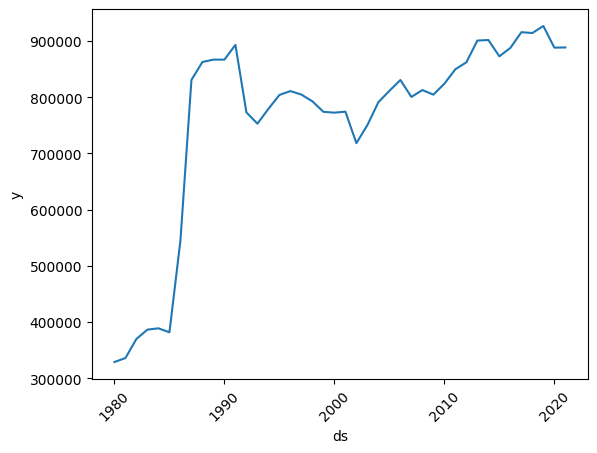

,unique_id,ds,y,population_1000s,lag1,lag2,lag3,rolling_mean_lag1_window_size2,diff_lag1_lag1,rolling_mean_lag2_window_size2,diff_lag2_lag1,rolling_mean_lag3_window_size2,diff_lag3_lag1
10542,World,1980,329165.9277,4444007.709,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10543,World,1981,336214.7531,4524627.657,329165.9277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10544,World,1982,370293.4367,4607984.872,336214.7531,329165.9277,NaN,332690.34040,7048.8254,NaN,NaN,NaN,NaN
10545,World,1983,386764.2394,4691884.240,370293.4367,336214.7531,329165.9277,353254.09490,34078.6836,332690.3404,7048.8254,NaN,NaN
10546,World,1984,389093.4765,4775836.077,386764.2394,370293.4367,336214.7531,378528.83805,16470.8027,353254.0949,34078.6836,332690.3404,7048.8254


In [375]:
transformed_data = fcst.preprocess(data, dropna=False)
query_country(transformed_data, unique_id ="World", target_col="y").head()

In [376]:
transformed_data.drop(columns=['unique_id', 'ds']).corr()['y']

y                                 1.000000
population_1000s                  0.932835
lag1                              0.993592
lag2                              0.984866
lag3                              0.975783
rolling_mean_lag1_window_size2    0.990884
diff_lag1_lag1                    0.197360
rolling_mean_lag2_window_size2    0.981999
diff_lag2_lag1                    0.211726
rolling_mean_lag3_window_size2    0.972791
diff_lag3_lag1                    0.209042
Name: y, dtype: float64

# Train and evaluate

In [377]:
# train = train.drop("population_1000s", axis=1)
fcst.fit(train, fitted=True, id_col='unique_id', time_col='ds', 
         target_col='y', static_features=[])

MLForecast(models=[XGBRegressor], freq=1, lag_features=['lag1', 'lag2', 'lag3', 'rolling_mean_lag1_window_size2', 'diff_lag1_lag1', 'rolling_mean_lag2_window_size2', 'diff_lag2_lag1', 'rolling_mean_lag3_window_size2', 'diff_lag3_lag1'], date_features=[], num_threads=6)

In [378]:
# temp_transf = transform_exog(future_df, lags=[1,2], 
#                              lag_transforms={1: [ExpandingMean()]})

In [379]:
# future_df = pd.concat([valid, projections]).drop('y', axis=1)
future_df = valid.drop('y', axis=1)
future_df.shape

(165, 3)

<Axes: xlabel='ds', ylabel='y'>

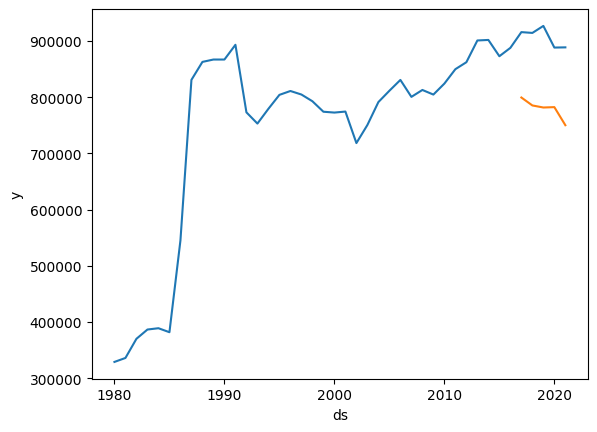

In [380]:
predictions = fcst.predict(h = 5, X_df=future_df)

sns.lineplot(data=query_country(data, "World"), x='ds', y='y')
sns.lineplot(data=query_country(predictions, "World"), x='ds', y='XGBRegressor')

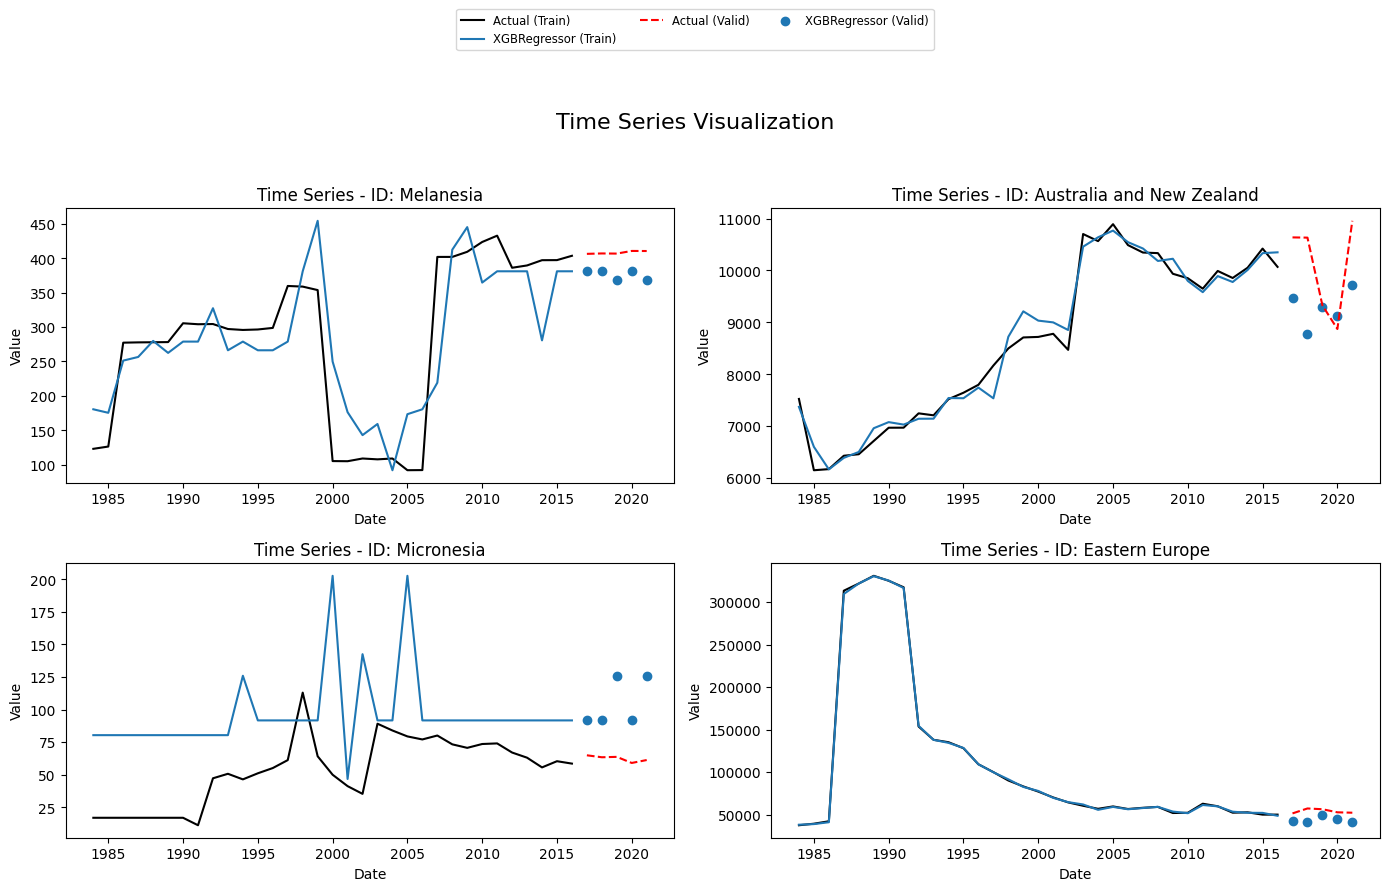

MEAN RMSE_VALID = 28246.860039534466

Model with lowest RMSE validation is XGBRegressor with RMSE = 28246.860039534466

              RMSE_train  R2_train   RMSE_valid  R2_valid
XGBRegressor  779.273213  0.999975  28246.86004   0.97614


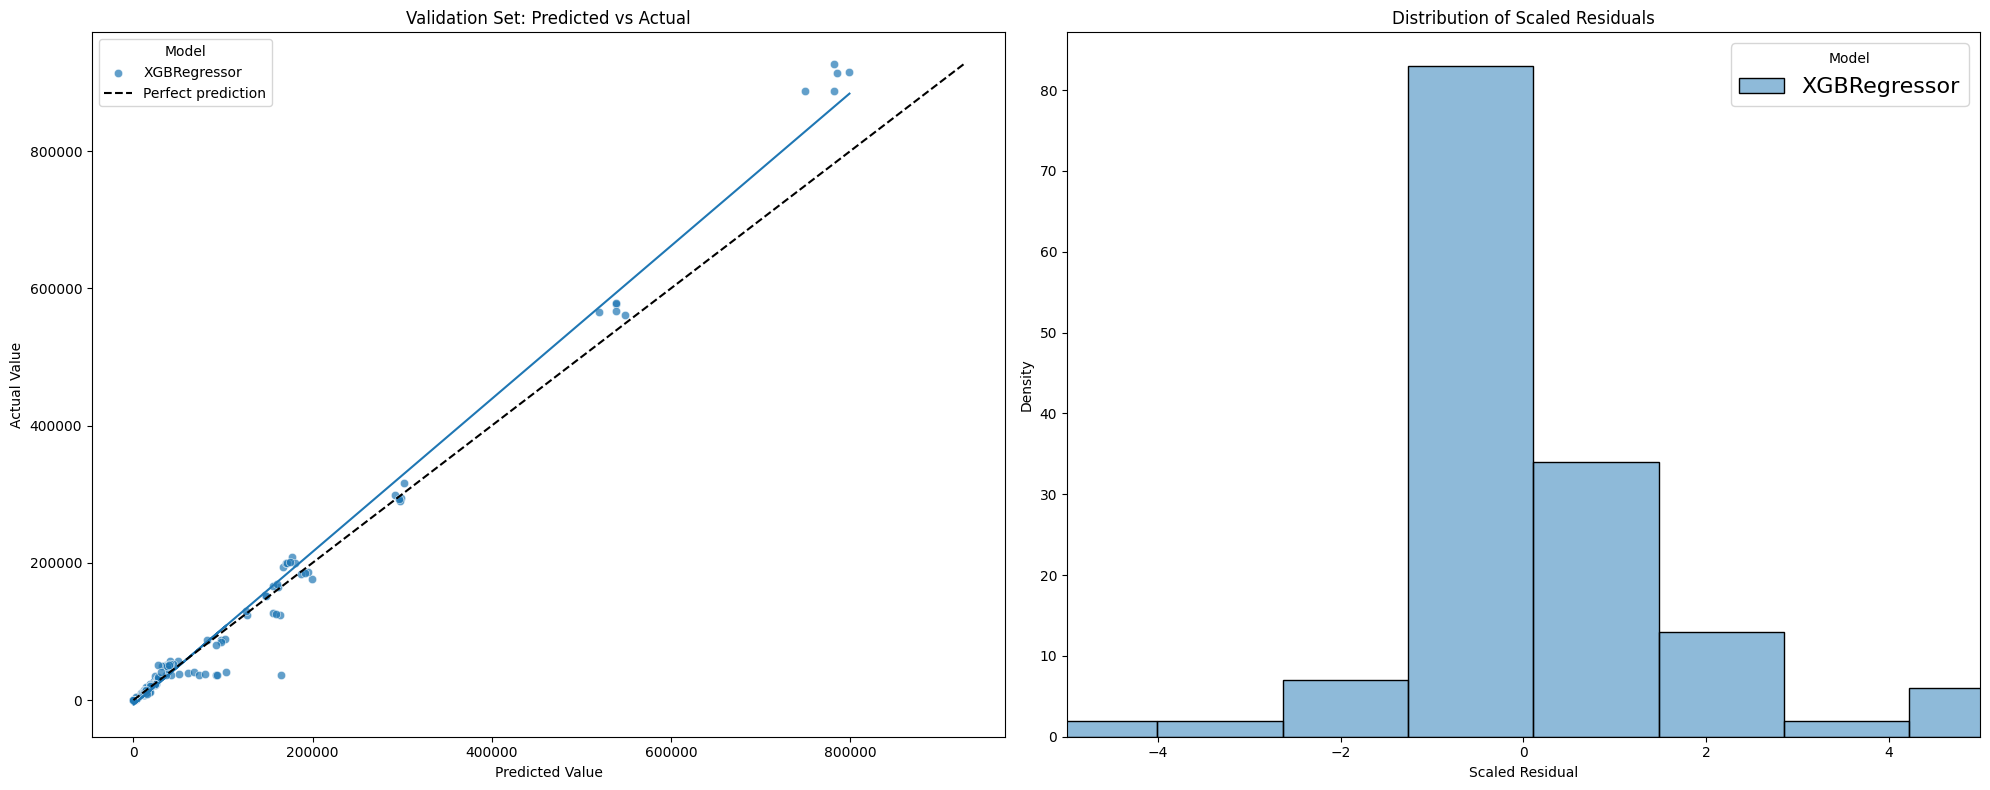

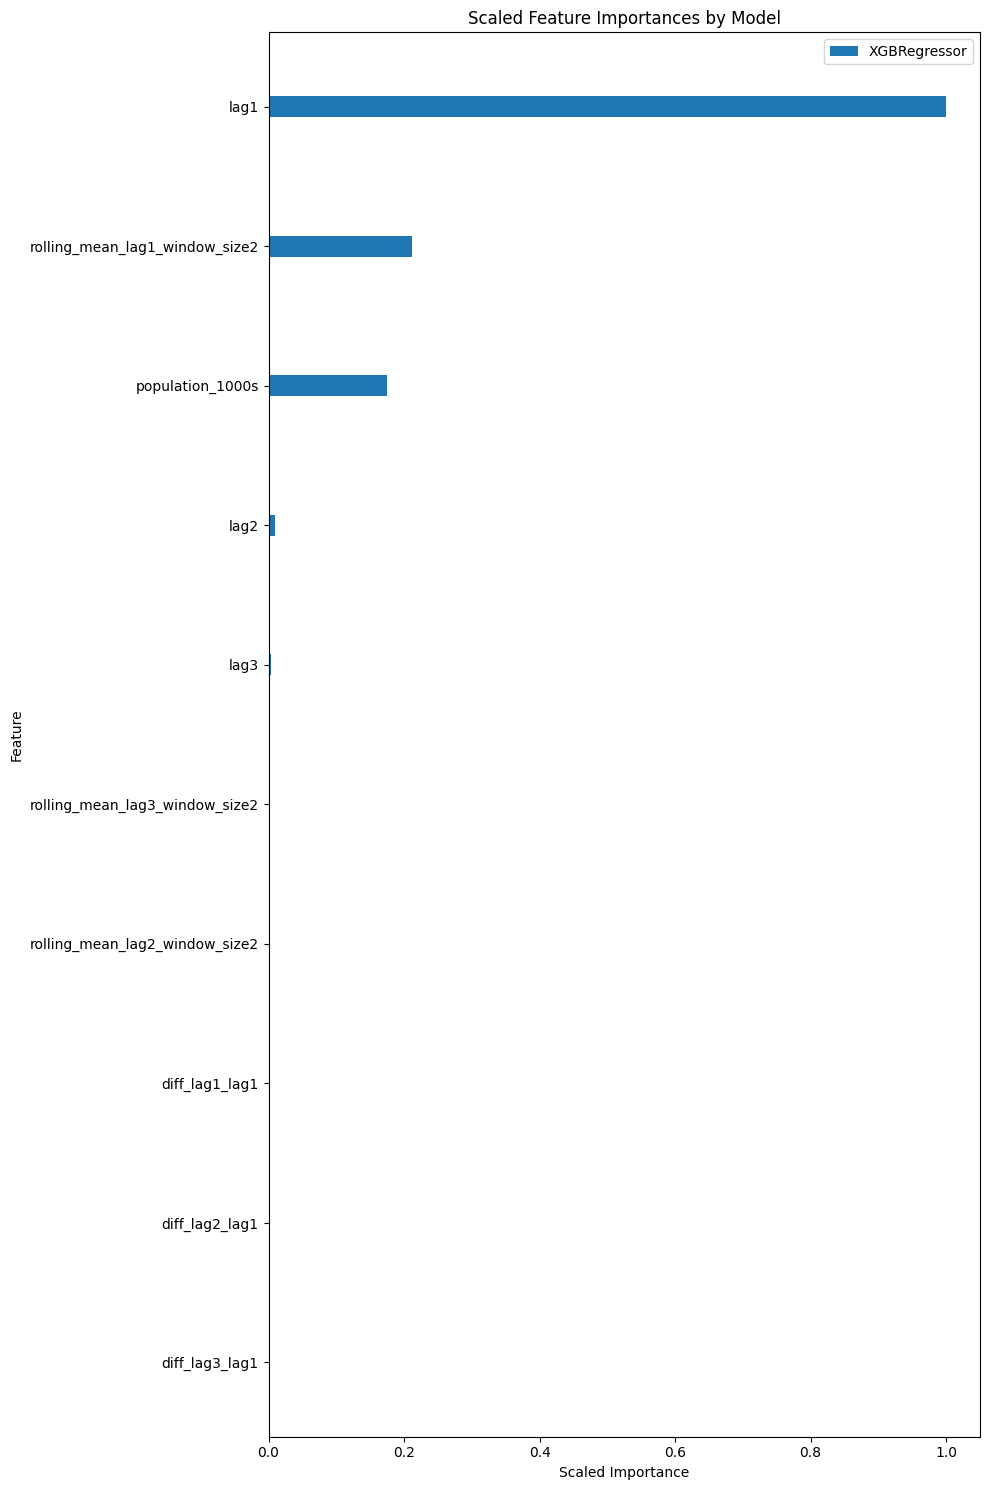

In [381]:
evaluator = MLForecast_Evaluator(fcst, valid, future_df, h=5)

# Plot time series
evaluator.plot_time_series(n_samples=4)  # Will show 4 random time series in a 2x2 grid

# Calculate and print metrics
evaluator.calculate_metrics()

# Plot metrics
evaluator.plot_metrics()

# Plot feature importances sorted by the average importance
evaluator.plot_feature_importances()